The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 学习率排定
:label:`sec_scheduler`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[贡献](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html)改进)

到目前为止，我们主要关注如何更新权重向量的优化 * 算法 *，而不是更新它们的 * 速率 *。尽管如此，调整学习率通常与实际算法同样重要。有许多方面需要考虑：

* 最明显的是，学习率的 * 大小 * 很重要。如果它太大，优化就会发生分歧，如果它太小，训练需要太长时间，或者我们最终得到了不理想的结果。我们之前看到问题的状况编号很重要（有关详细信息，请参见 :numref:`sec_momentum`）。直观地说，这是最不敏感方向的变化量与最敏感方向的变化量的比率。
* 其次，衰变速度同样重要。如果学习率仍然很高，我们可能最终会在最低水平上反弹，从而无法达到最佳性。:numref:`sec_minibatch_sgd` 比较详细地讨论了这一点，我们在 :numref:`sec_sgd` 中分析了绩效保证。简而言之，我们希望汇率衰减，但可能比 $\mathcal{O}(t^{-\frac{1}{2}})$ 慢，这将是解决凸问题的不错选择。
* 另一个同样重要的方面是 * 初始化 *。这既涉及参数最初的设置方式（详情请参阅 :numref:`sec_numerical_stability`），也关系到它们最初的演变方式。这是 *warmup* 的名字，即我们最初开始向解决方案迈进的速度有多快。一开始的大步骤可能没有益处，特别是因为最初的一组参数是随机的。最初的更新方向可能也是毫无意义的。
* 最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围。我们建议读者阅读 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018` 中的详细信息，例如，如何通过对整个 * 路径 * 参数进行平均值来获得更好的解决方案。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动处理这个问题的工具。在本章中，我们将回顾不同时间表对准确性的影响，并展示如何通过 * 学习费率计划器 * 有效管理这一点。

## 玩具问题

我们从一个玩具问题开始，这个问题很便宜，可以轻松计算，但足以说明一些关键方面。为此，我们选择了一个稍微现代化的 Lenet 版本（`relu` 而不是 `sigmoid` 激活，MaxPooling 而不是平均的 Pooling），适用于时尚 MNIST。此外，我们为了提高性能而混合网络。由于大多数代码都是标准的，我们只是介绍基础知识而不进一步详细讨论。根据需要进修，请参阅 :numref:`chap_cnn`。


In [1]:
%matplotlib inline
import math
import tensorflow as tf
from d2l import tensorflow as d2l
from tensorflow.keras.callbacks import LearningRateScheduler


def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='relu'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu(), custom_callback = False):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = d2l.TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    if custom_callback is False:
        net.fit(train_iter, epochs=num_epochs, verbose=0,
                callbacks=[callback])
    else:
         net.fit(train_iter, epochs=num_epochs, verbose=0,
                 callbacks=[callback, custom_callback])
    return net

让我们来看看如果我们使用默认设置调用此算法，例如学习率为 $0.3$ 并训练 $30$ 次迭代，会发生什么情况。请注意，在测试准确度方面的进展停滞超过一点时，训练准确度如何持续提高。两条曲线之间的间隙表示过度拟合。


loss 0.207, train acc 0.923, test acc 0.894
66911.9 examples/sec on /GPU:0


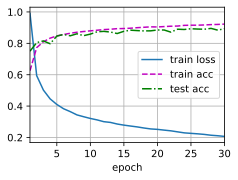

In [2]:
lr, num_epochs = 0.3, 30
train(net, train_iter, test_iter, num_epochs, lr)

## 调度程序

调整学习率的一种方法是在每一步明确设置学习率。这可以通过 `set_learning_rate` 方法方便地实现。我们可以在每个时代之后（甚至在每个迷你批次之后）向下调整它，例如，以动态的方式来响应优化的进展情况。


In [3]:
lr = 0.1
dummy_model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
dummy_model.compile(tf.keras.optimizers.SGD(learning_rate=lr), loss='mse')
print(f'learning rate is now ,', dummy_model.optimizer.lr.numpy())

learning rate is now , 0.1


更一般来说，我们想定义一个调度程序。当调用更新次数时，它将返回学习率的适当值。让我们定义一个简单的方法，将学习率设置为 $\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。


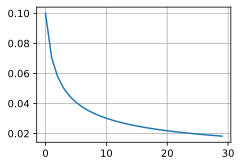

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对 Fashion-MNIST 的训练有何影响。我们只是提供调度程序作为训练算法的额外参数。


loss 0.382, train acc 0.859, test acc 0.846
83497.1 examples/sec on /GPU:0


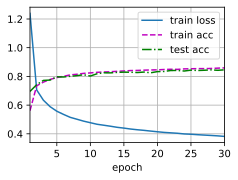

In [6]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

这比以前好一些。有两点突出：曲线比以前更加平滑。其次，没那么过分适合。不幸的是，为什么某些策略会导致 * 理论 * 不太适合，这还不是一个解决得很好的问题。有一些观点认为，较小的步长将导致更接近零的参数，从而更简单。但是，这并不能完全解释这种现象，因为我们并没有真正提前停止，而只是轻轻地降低学习率。

## 政策

虽然我们不可能涵盖所有各种学习费率计划器，但我们尝试在下面简要概述热门政策。常见的选择是多项式衰减和分段恒定时间表。除此之外，人们发现余弦学习率时间表在一些问题上在经验上效果很好。最后，在某些问题上，最好在使用较高的学习率之前预热优化器。

### 因子调度器

多项式衰变的一种替代方案是乘法衰变，即 $\alpha \in (0, 1)$ 的 $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。为了防止学习率衰减超出合理的下限，更新方程经常修改为 $\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


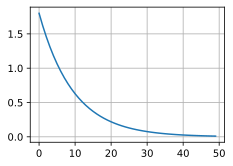

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(tf.range(50), [scheduler(t) for t in range(50)])

这也可以通过 MXNet 中的内置调度程序通过 `lr_scheduler.FactorScheduler` 对象来实现。它还需要一些参数，例如预热时间、预热模式（线性或恒定）、所需更新的最大数量等；未来，我们将酌情使用内置的调度程序，并仅在此解释它们的功能。如图所示，如果需要，构建自己的调度程序相当简单。

### 多因素调度器

培训深度网络的一种常见策略是保持逐段稳定的学习率，并且每隔一次将学习率降低给定的数量。也就是说，给定一组降低利率的时间，例如 $s = \{5, 10, 20\}$ 每当 $t \in s$ 时降低 $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。假设每个步骤中的值减半，我们可以按如下方式实现这一点。


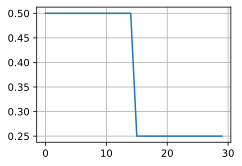

In [8]:
class MultiFactorScheduler:
    def __init__(self, step, factor, base_lr):
        self.step = step
        self.factor = factor
        self.base_lr = base_lr

    def __call__(self, epoch):
        if epoch in self.step:
            self.base_lr = self.base_lr * self.factor
            return self.base_lr
        else:
            return self.base_lr

scheduler = MultiFactorScheduler(step=[15, 30], factor=0.5, base_lr=0.5)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

这个分段恒定学习率时间表背后的直觉是，让优化继续进行，直到在体重向量分布方面达到固定点为止。然后（只有这样）我们会将利率降低，例如获得更高质量的代理服务器，达到良好的本地最低水平。下面的例子显示了这如何能够产生更好的解决方案。


loss 0.230, train acc 0.915, test acc 0.888
82988.7 examples/sec on /GPU:0


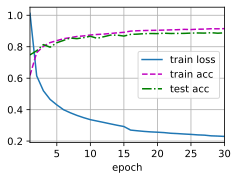

In [9]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

### 余弦调度器

:cite:`Loshchilov.Hutter.2016` 提出了一种相当令人困惑的启发式算法。它所依据的观点是，我们可能不想在一开始就太大地降低学习率，而且我们最终可能希望用非常小的学习率来 “改进” 解决方案。这导致了类似于奖金的时间表，其中包含以下功能形式的学习率在 $t \in [0, T]$ 范围内。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里是 $\eta_0$ 是初始学习率，$\eta_T$ 是当时 $T$ 的目标学习率。此外，对于 $t > T$，我们只需将价值固定到 $\eta_T$，而不再增加它。在下面的示例中，我们设置了最大更新步骤 $T = 20$。


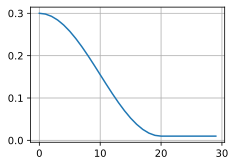

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉的背景下，这个时间表 * 可以 * 导致改善结果。但是，请注意，这种改进并不能保证（如下所示）。


loss 0.263, train acc 0.904, test acc 0.882
82921.9 examples/sec on /GPU:0


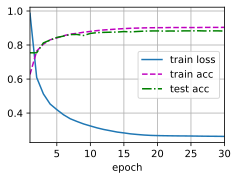

In [11]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

### 热身

在某些情况下，初始化参数不足以保证良好的解决方案。这对于某些高级网络设计来说尤其是一个问题，可能导致不稳定的优化问题我们可以通过选择足够小的学习率来解决这个问题，以防止一开始发生分歧。不幸的是，这意味着进展缓慢。相反，较高的学习率最初会导致差异。

解决这种困境的一个相当简单的解决方法是使用预热期间，在此期间学习率 * 将 * 增加 * 至初始最大值，并将速度降温到优化过程结束。为了简单起见，为此，通常使用线性增加。这导致了以下表格的时间表。


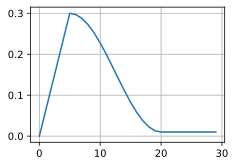

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

请注意，网络最初收敛得更好（特别是观察前 5 个时期的性能）。


loss 0.270, train acc 0.902, test acc 0.882
83222.8 examples/sec on /GPU:0


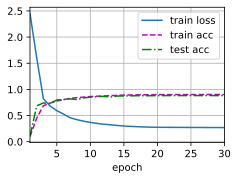

In [13]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

热身可以应用于任何调度程序（不仅仅是余弦）。有关学习率计划和更多实验的更详细讨论，另请参阅 :cite:`Gotmare.Keskar.Xiong.ea.2018`。特别是，他们发现，热身阶段限制了非常深的网络中参数的差异量。这直觉上是有道理的，因为我们预计由于网络中最需要一开始取得进展的那些部分随机初始化，因此我们预计会出现巨大的差异。

## 摘要

* 在训练期间降低学习率可以提高准确性，并且（最令人困惑的是）减少模型的过度拟合。
* 每当进展缓慢时，逐步降低学习率在实践中是有效的。基本上，这可以确保我们有效地融合到合适的解决方案，然后才通过降低学习率来减少参数的固有差异。
* 余弦调度程序在某些计算机视觉问题中很受欢迎。例如，请参阅 [GluonCV](http://gluon-cv.mxnet.io) 了解此类调度程序的详细信息。
* 优化之前的预热期可以防止背离。
* 优化在深度学习中有多种用途。除了最大限度地减少训练目标之外，不同的优化算法和学习率计划选择可能会导致测试集的概括量和过度拟合（对于同样量的训练错误）。

## 练习

1. 试验给定固定学习率的优化行为。这种方式可以获得的最佳模型是什么？
1. 如果你改变学习率下降的指数，收敛性会如何改变？为了方便在实验中使用 `PolyScheduler`。
1. 将余弦调度器应用于大型计算机视觉问题，例如训练 ImageNet。相对于其他调度程序，它如何影响性能？
1. 热身应该持续多长时间？
1. 你能连接优化和采样吗？首先，在随机渐变 Langevin 动力学上使用 :cite:`Welling.Teh.2011` 的结果。


[Discussions](https://discuss.d2l.ai/t/1081)
